<a href="https://colab.research.google.com/github/masdatascience/AI/blob/master/Test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install turicreate
!pip install lifetimes

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
import turicreate as tc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
import sys
sys.path.append("..")
## Algoritmos de ML
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC as svc 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import tree
import graphviz 
from sklearn import metrics

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

datos productos: (32951, 10)
datos clientes: (96352, 4)
datos facturación: (100010, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/lifetimes/generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a 

1    95844
2      248
3        4
dtype: int64

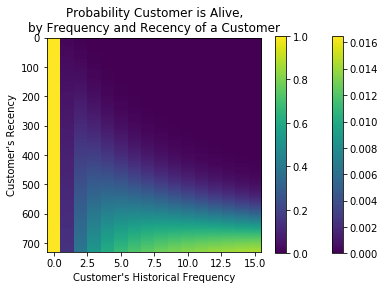

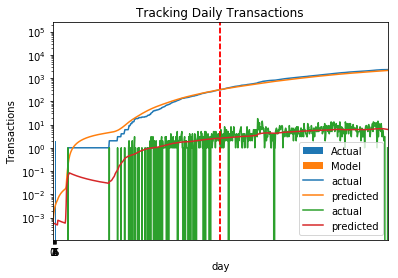

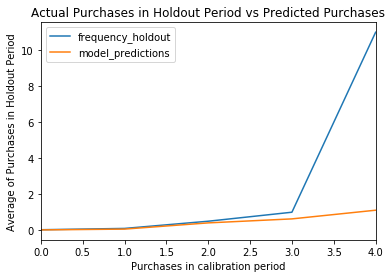

In [2]:
url = 'https://github.com/masdatascience/TFM-AI/blob/master/transacciones.xlsx?raw=true'
datos_modelo_completo = pd.ExcelFile(url)
datos_facturacion = pd.read_excel(datos_modelo_completo, sheet_name='transacciones')
# Se elimian los datos nulos de las dimensiones importantes del analisis que son productos y clientes
datos_facturacion = datos_facturacion.dropna(subset=['customer_id'])
#datos_facturacion = datos_facturacion.dropna(subset=['product_id'])
# Se elimina posibles chargeback que se presenten
url1 = 'https://github.com/masdatascience/TFM-AI/blob/master/data_model_completo.xlsx?raw=true'
datos_modelo_completo = pd.ExcelFile(url1)
#datos_facturacion = datos_facturacion.loc[datos_facturacion['total_value'] > 0]
datos_producto = pd.read_excel(datos_modelo_completo, sheet_name='product')
datos_clientes = pd.read_excel(datos_modelo_completo, sheet_name='customer')
print("datos productos: "+str(datos_producto.shape))
print("datos clientes: "+str(datos_clientes.shape))
print("datos facturación: "+str(datos_facturacion.shape))
# se visualiza el número de comrpas que tiene un cliente
datos_clientes.groupby('customer_id').size().value_counts()
datos_facturacion.groupby('customer_id').size().value_counts()
datos_facturacion['date'] = pd.to_datetime(datos_facturacion['order_purchase_timestamp'])
datos_facturacion = datos_facturacion.drop('order_purchase_timestamp',axis=1)
# se realiza un subconjunto de columnas con los cuales se analizará el comportamiento de compra
transaction_data = datos_facturacion[['customer_id','date','price']]
# se crea el modelo RFM
summary = summary_data_from_transaction_data(transaction_data,'customer_id','date',monetary_value_col='price',)
t=1
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
plot_frequency_recency_matrix(bgf);
plot_probability_alive_matrix(bgf)
plot_period_transactions(bgf).set_yscale('log');
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary_cal_holdout = calibration_and_holdout_data(datos_facturacion, 'customer_id', 'date',calibration_period_end='2017-09-03', observation_period_end='2018-09-03' )
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, datos_facturacion, 'date', 'customer_id', 730, 365);
plot_incremental_transactions(bgf, datos_facturacion, 'date', 'customer_id', 730, 365);
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);
datos_clientes.groupby('customer_id').size().value_counts()


churned        1932
high risk        81
not churned      72
Name: churn, dtype: int64

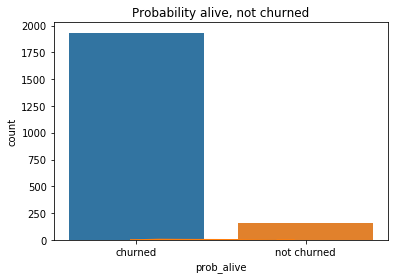

In [3]:
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive']);
df['churn'] = ['churned' if p < .1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn']);
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned');
df['churn'][(df['prob_alive']>=.1) & (df['prob_alive']<.2)] = "high risk"
df['churn'].value_counts()

In [0]:
def labelDatase(dataset):

  le = preprocessing.LabelEncoder()

  for column_name in dataset.columns:
        if dataset[column_name].dtype == object:
            dataset[column_name] = le.fit_transform(dataset[column_name])
        else:
            pass

  return dataset

In [5]:
print(summary.median())
df['is_churn'] = np.where( (df['frequency']<1) & (df['T']>400) & (df['recency']<1) & (df['recency']<0.000044), 1, 0) 
summary['is_churn'] = np.where( (summary['frequency']<1) & (summary['T']>400) & (summary['recency']<1) & (summary['recency']<0.000044), 1, 0) 
prueba_clientes = pd.merge(datos_clientes,summary[['is_churn']],on='customer_id', how='left')
prueba_clientes = pd.merge(prueba_clientes,datos_facturacion[['customer_id','seller_id']].drop_duplicates(),on='customer_id', how='left')
prueba_clientes['is_churn'].fillna(0, inplace=True)
prueba_clientes['seller_id'].fillna(0, inplace=True)
print(prueba_clientes.count())
prueba_clientes.groupby('is_churn').count()
prueba_clientes['is_churn'].mean()

frequency                0.000000
recency                  0.000000
T                      227.000000
monetary_value           0.000000
predicted_purchases      0.000054
dtype: float64
customer_id                 100232
customer_state              100232
customer_city               100232
customer_zip_code_prefix    100232
is_churn                    100232
seller_id                   100232
dtype: int64


0.17545294915795354

In [6]:
enconder = LabelEncoder()


dataset =  prueba_clientes.drop(['customer_id','customer_city','seller_id'], axis=1)
ds_customer_city = pd.get_dummies(prueba_clientes.customer_city).iloc[:,1:]
#ds_seller_id = pd.get_dummies(prueba_clientes.seller_id.astype('category').cat.codes).iloc[:,1:]
ds_seller_id = pd.get_dummies(prueba_clientes.seller_id).iloc[:,1:]
customer = pd.concat([dataset,ds_customer_city,ds_seller_id], axis=1)
#customer['customer_id']= enconder.fit_transform(customer["customer_id"])
customer['customer_state']= enconder.fit_transform(customer["customer_state"])
print(customer.shape)
customer.head()

(100232, 7216)


,customer_state,customer_zip_code_prefix,is_churn,abadiania,abaete,abaetetuba,abaiara,abaira,abare,abatia,abdon batista,abelardo luz,abrantes,abre campo,abreu e lima,acaiaca,acailandia,acajutiba,acarau,acari,acegua,acopiara,acreuna,acu,acucena,adamantina,adhemar de barros,adolfo,adrianopolis,adustina,afogados da ingazeira,afonso claudio,afranio,agisse,agrestina,agrolandia,agronomica,agua boa,agua branca,agua clara,...,fd386aa7bed2af3c7035c65506c9b4a3,fd435faa3c0422b60440ea3480d0e77c,fdaaf5bfda82b7b80535610c831b8d09,fdb9095204a334cd8872252ffec6f2db,fde0cc9ea29c8ccfc0a2c22256a58c71,fdf736c18c589ed030e058312203e1b2,fe19dce63ae80346207c6c55713d1023,fe1b067411b8c5066e962aa146ccee03,fe1bbc5feda5c8979a8a1b3b2512d5a6,fe2032dab1a61af8794248c8196565c9,fe26f3ecb51a15e6d8335cd92da42562,fe49ee029e61e789a1f3a5525f57ba8d,fe4cd9461203cee790d36792420b310f,fe701d88b67eaca109dffd464d1be9f9,fe8055980a4ff7f64ed889c2b5926929,fe87f472055fbcf1d7e691c00b1560dc,fe9d9cf8631285d5982c6e2cf27fb114,feb793c88d836c3a75efa4b5a3465d70,febab0275244b9a49a623f0bd613ca2f,fec6275253471ace26d209bbaa64cd0f,fec6912baad85d41729669edd6b4d3b8,fec8cd45395b3cb0c2b173d7739706a1,fedaedd3ca31d56ab33e92035e4b361c,fedf2c1386e137f296b3bbf3b635e69d,ff063b022a9a0aab91bad2c9088760b7,ff1e15b778c700abdd4d239b81ac466d,ff1fb4c404b2efe68b03350a8dc24122,ff314fa6033cc68ec451c47aee2d6ba4,ff4e2d38692ce827b1a4f4b8196e680d,ff4ea69c2a729e83e63c7579e4ef8170,ff69aa92bb6b1bf9b8b7a51c2ed9cf8b,ff82e8873fba613f2261a9acc896fd84,ffa6adafb71b807dc13159e26431354c,ffad1e7127fb622cb64a900751590acd,ffc470761de7d0232558ba5e786e57b7,ffcfefa19b08742c5d315f2791395ee5,ffdd9f82b9a447f6f8d4b91554cc7dd3,ffeee66ac5d5a62fe688b9d26f83f534,fffd5413c0700ac820c7069d66d98c89,ffff564a4f9085cd26170f4732393726
0,25,7787,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,25,6053,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,23,88115,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13,66812,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,25,18040,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
print(customer.shape)
# se obtiene X y Y , además los datasets de entrenamiento y pruebas
features = customer.drop(['is_churn'], axis=1)
labels = customer['is_churn']
print(features.shape)
print(labels.shape)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=1)

(100232, 7216)
(100232, 7215)
(100232,)


In [8]:
# Algoritmo Random Forest
rfc_object = rfc(n_estimators=200, random_state=0)
rfc_object.fit(train_features, train_labels)
predicted_labels = rfc_object.predict(test_features)
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

KeyboardInterrupt: ignored

In [0]:
# Regresión lineal
# Algoritmo
lr_object = LogisticRegression()
lr_object.fit(train_features, train_labels)
predicted_labels = lr_object.predict(test_features)
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

In [0]:
# arbol de decision
from sklearn import tree
import graphviz 
# Create each decision tree (pruned and unpruned)
decisionTree_unpruned = tree.DecisionTreeClassifier()
decisionTree = tree.DecisionTreeClassifier(max_depth = 4)
 
# Fit each tree to our training data
decisionTree_unpruned = decisionTree_unpruned.fit(X=train_features, y=train_labels)
decisionTree = decisionTree.fit(X=train_features, y=train_labels)
 
# Generate PDF visual of decision tree
churnTree = tree.export_graphviz(decisionTree, out_file=None, 
                         feature_names = list(train_features.columns.values),  
                         class_names = ['No churn', 'Churn'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(churnTree)
graph.render('decision_tree.gv', view=True)
predicted_labels = decisionTree.predict(test_features)
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

In [0]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Create Gradient Boosting Classifier
gb = GradientBoostingClassifier()
#Train the model using the training sets
gb.fit(train_features, train_labels)
#Predict the response for test dataset
predicted_labels = gb.predict(test_features)


# Model Accuracy, how often is the classifier correct?
#print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))
# Model Precision
#print("Precision:",metrics.precision_score(test_labels, y_pred))
# Model Recall
#print("Recall:",metrics.recall_score(test_labels, y_pred))


print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
# Se genera el modelo 
modelo = Sequential()

#Se define un monitor de parada temprana para que el modelo deje de entrenar cuando ya no mejore
early_stopping_monitor = EarlyStopping(patience=3)

#Se obtienen las columnas de entrenamiento

scale = StandardScaler()
X_dataset = scale.fit_transform(features)

Y_dataset =labels.values 
n_cols = X_dataset.shape[1]

#Se agregan las capas, aumentar el número de nodos en cada capa aumenta la capacidad del modelo pero por Collab lo dejare en esa cantidad
# La función de activación que utilizaremos es ReLU o activación lineal rectificada. 
# Aunque se trata de dos piezas lineales, se ha demostrado que funciona bien en redes neuronales.

modelo.add (Dense (128, activation = 'relu', input_shape = (n_cols,))) 
modelo.add( Dropout(0.3))
modelo.add (Dense (64, activation = 'relu')) 
modelo.add( Dropout(0.25))
modelo.add (Dense (64, activation = 'sigmoid')) 
modelo.add( Dropout(0.4))
modelo.add (Dense (64, activation = 'sigmoid')) 
modelo.add( Dropout(0.25))
modelo.add (Dense (1, activation = 'sigmoid')) 

#modelo.add(layers.Flatten())
#Una función de activación permite a los modelos tener en cuenta las relaciones no lineales. 
#Por ejemplo, si predice la diabetes en los pacientes, pasar de los 10 a los 11 años es diferente a los de los 60 a los 61 años.
#La activación es 'softmax'. Softmax hace que la sum
  # compilar el modelo utilizando la precisión para medir el rendimiento del modelo 
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resultado=modelo.fit(X_dataset, Y_dataset, batch_size=10, epochs=100, validation_split=0.4, callbacks=[early_stopping_monitor])
#guardarResultado(resultado,'PROPIA2_EXP1')

Using TensorFlow backend.
W0903 23:18:57.064587 140514505668480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 23:19:23.738768 140514505668480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 23:19:23.743086 140514505668480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 23:19:23.761584 140514505668480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

Train on 60139 samples, validate on 40093 samples
Epoch 1/100
60139/60139 [==============================] - 88s 1ms/step - loss: 0.4048 - acc: 0.8248 - val_loss: 0.3617 - val_acc: 0.8353
Epoch 2/100
60139/60139 [==============================] - 84s 1ms/step - loss: 0.3334 - acc: 0.8485 - val_loss: 0.3691 - val_acc: 0.8371
Epoch 3/100
60139/60139 [==============================] - 83s 1ms/step - loss: 0.3132 - acc: 0.8575 - val_loss: 0.3950 - val_acc: 0.8361
Epoch 4/100
60139/60139 [==============================] - 85s 1ms/step - loss: 0.3048 - acc: 0.8624 - val_loss: 0.3884 - val_acc: 0.8346


In [12]:
predicted_labels = modelo.predict(test_features)
# Model Accuracy, how often is the classifier correct?
#print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))
# Model Precision
#print("Precision:",metrics.precision_score(test_labels, y_pred))
# Model Recall
#print("Recall:",metrics.recall_score(test_labels, y_pred))
print(classification_report(test_labels, predicted_labels.round()))
print(confusion_matrix(test_labels, predicted_labels.round()))
print(accuracy_score(test_labels, predicted_labels.round()))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     16493
         1.0       0.18      1.00      0.30      3554

    accuracy                           0.18     20047
   macro avg       0.09      0.50      0.15     20047
weighted avg       0.03      0.18      0.05     20047

[[    0 16493]
 [    0  3554]]
0.1772833840474884


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
print(classification_report(test_labels, predicted_labels.round()))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     16493
         1.0       0.18      1.00      0.30      3554

    accuracy                           0.18     20047
   macro avg       0.09      0.50      0.15     20047
weighted avg       0.03      0.18      0.05     20047



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# SVM
# Algoritmo
svc_object = svc(kernel='rbf', degree=8)
svc_object.fit(train_features, train_labels)
predicted_labels = svc_object.predict(test_features) 
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))